<a href="https://colab.research.google.com/github/james811223/Traffic-Sign-Recognition-With-CNN/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Traffic Signs](https://www.kaggle.com/valentynsichkar/traffic-signs-preprocessed)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Setting up

In [0]:
if 1==1:
    !sudo pip install tensorflow --upgrade
    !pip install --user --upgrade plotnine
    from matplotlib import pyplot as plt
    import tensorflow as tf,ast,random,numpy as np,pandas as pd,pickle
    from sklearn.preprocessing import OneHotEncoder as code
    data0 = pickle.load(open('/content/drive/My Drive/data0.pickle', 'rb'), encoding='latin1')
    x=np.concatenate([data0['x_test'],data0['x_validation'],data0['x_train']])
    y=np.concatenate([data0['y_test'],data0['y_validation'],data0['y_train']])
    from plotnine import *
    !pip install dfply
    from dfply import *
    %matplotlib inline
    batch_norm=tf.nn.batch_normalization
    theme_update(plot_background = element_rect(fill = "orange"),panel_background = element_rect(fill = "silver",colour = "blue",size = 1.99,linetype = "solid"),plot_title = element_text(hjust = 0.5))
    convolution=tf.keras.layers.Convolution2D
    max_pool=tf.keras.layers.MaxPool2D
    full_connect=tf.keras.layers.Flatten
    avg_pool=tf.keras.layers.AveragePooling2D
    dense=tf.keras.layers.Dense

# Function to show sample images

In [0]:
def sample_img(imgs,rows=3,cols=6):
    """
    imgs: numpy array of images
        Supported shapes are:
            - (M, N): an image with scalar data. The data is visualized using a colormap.
            - (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
            - (M, N, 4): an image with RGBA values (0-1 float or 0-255 int).
    rows: rows of images to show.
    cols: columns of images to show.
    Total sample images show is rows * cols
    """
    imgs=imgs.astype(int)
    idx=random.sample(range(imgs.shape[0]),rows*cols)
    idx=np.array(idx).reshape(rows,cols)
    stick=np.concatenate(imgs[idx[0]],axis=1)
    for i in range(1,rows):
        col_stick=np.concatenate(imgs[idx[i]],axis=1)
        stick=np.concatenate([stick,col_stick],axis=0)
    plt.imshow(stick, interpolation='nearest');plt.show()

# Display some images from data

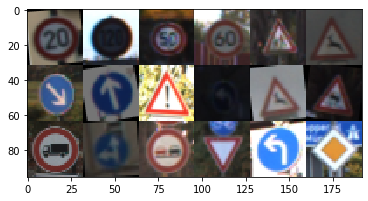

In [29]:
sample_img(x.transpose(0,2,3,1))

# Class for building CNN

In [0]:
class cnn:
    '''
    Wrapper class to build CNN model with Tensorflow and Keras.
    Parameters:
        data(numpy array)- Training data
        label(numpy array or list)- Labels for training data
        categories(optional list)- Categories matching the order of label indexing.
        rescale(bool defaults to true)- Whether to rescale data to range [0,1] or not, when the data is not in range of [0,1].
        image(str defaults to gray)- gray or rbg
        train(float or int)- Indicate how much data to be used for training. If integer is given, the imput number of data will be used for training. 
                            If float(must be in [0,1)) is given, portion of the data will be used for training.
    '''
    def __init__(self,data,label,categories=None,rescale=1==1,image='gray',train=.7):
        self.switch=1==1
        self.rescale=rescale
        if image=='gray': self.chanel=1
        elif image=='rbg': self.chanel=3
        data=self.preprocess(data)
        raw_x_shape=list(data.shape)
        if image=='gray':
            if len(raw_x_shape)==3:
                pixels=raw_x_shape[-1]*raw_x_shape[-2]
            else:
                pixels=raw_x_shape[-1]
        elif image=='rbg':
            if len(raw_x_shape)==3:
                pixels=raw_x_shape[-2]
            else:
                pixels=raw_x_shape[-2]*raw_x_shape[-3]
        raw_x_shape[0]=None
        if categories is not None:self.categories=categories
        self.data=self.split(data,label,train)
        self.classes=len(np.unique(self.data['y_train']))
        if (image=='gray' and len(self.data['x_train'].shape)==2) or (image=='rbg' and len(self.data['x_train'].shape)==3):
            self.x=self.data['x_train'].reshape([-1,int(pixels**.5),int(pixels**.5),self.chanel])
        else:self.x=self.data['x_train']
        self.conv=[]
        self.fc=dict()
        self.switch=1==2
        self.maps=[]

    @staticmethod
    def split(x,y,train):
        '''
        Split data and labels into training, testing, and validation data sets. A dictionary is returned.
        Parameters:
            x(numpy array)- data
            y(numpy array)- labels
            train(int or float in range (0,1))- If int, specified number of data will be used for training. If float portion of data will be used.
        '''
        rand_idx=random.sample(range(x.shape[0]),x.shape[0])
        x=x[rand_idx];y=y[rand_idx]
        if type(train)==float:
            train=int(x.shape[0]*train//1)
        data=dict()
        data['x_train'],data['x_test']=np.split(x,[train])
        data['y_train'],data['y_test']=np.split(y,[train])
        return data

    def preprocess(self,data):
        if self.chanel==3:
            shape=list(data.shape)
            channel_idx=shape.index(3)
            if shape[-1] != channel_idx:
                if len(shape)==3:
                    data=data.transpose(0,2,1)
                elif len(shape)==4:
                    data=data.transpose(0,2,3,1)
        if np.max(data) > 1:
            if self.rescale:return data/255
            else: return data
        else: return data
                
    @staticmethod
    def int2list(num):
        if type(num)==int:
            return [num,num]
        else: return num

    def get_list(self,x,arg,n):
        if arg=='kernal_shapes':
            if type(x)==int:
                return [self.int2list(x) for nn in n]
            elif type(x)==list:
                return [self.int2list(s) for s in x]
            elif type(x)==tuple:
                return [list(x) for nn in n]
            else: raise ValueError('Invalid kernal_shapes argument. Please read doc string.')
        elif arg in ['conv_strides','pool_kernals','pool_strides']:
            if type(x)==int:
                return [self.int2list(x) for nn in n]#[[1]+self.int2list(x)+[self.chanel] for nn in n]
            elif type(x)==list:
                return [self.int2list(s) for s in x]#[[1]+self.int2list(s)+[self.chanel] for s in x]
            elif type(x)==tuple:
                return [list(x) for nn in n]#[[1]+list(x)+[self.chanel] for nn in n]
            else: raise ValueError('Invalid conv_strides argument. Please read doc string.')

    @staticmethod
    def pool(method,kernal,stride,pad):
        if method=='max':
            return max_pool(kernal,stride,pad)
        elif method=='avg':
            return avg_pool(kernal,stride,pad)
        else:
            raise ValueError('Unrecognized or unsupported pooling option.')

    def build(self,n_maps,conv_strides=1,kernal_shapes=5,pool_kernals=2,pool_strides=2,pads='SAME',act_fns='relu',pools='max',drop=.1,dense_units=None):
        '''
            n_maps(list of integers)- Specifies the number of feature maps in each convolution layers.
                Example >> nmaps=[32,64] sets up convolution layer 1 with 32 feature maps, and 64 for layer 2.
            conv_strides(int, tuple, or list defaults to 1)- Specifies strides used for convolution operation for each convolution layers.
                Example >> conv_strides=1 use strides 1 by 1 for all convolution operations.
                           conv_strides=(1,2) use strides 1 by 2 for all convolution operations.
                           conv_strides=[1,2,[2,1],3] use strides 1 by 1 for first convolution operation, 2 by 2 for second, 2 by 1 for third, and 3 by 3 for last.
                           conv_strides=[1,2] use strides 1 by 1 for first convolution operation and 2 by 2 for last.
            kernal_shapes(int, tuple, or list defaults to 5)- Specifies filter used for convolution operation for each convolution layers.
            pool_kernals(int, tuple, or list defaults to 2)- Specifies kernal used for pooling operation for each convolution layers.
            pool_strides(int, tuple, or list defaults to 2)- Specifies strides used for pooling operation for each convolution layers.
            pads(str or list of str defaults to SAME with VALID as an alternative)- Padding options to be used for convolution and pooling operations in each layers.
            act_fns(str or list of str defaults to relu with elu, sigmoid, leaky elu, selu, tanh as alternatives)- Activation function to be used for convolution operations in each layers.
            pools(str or list of str defaults to max with avg as an alternative)- Pooling option to be used in each layers.
            drop(float or list defaults to 0.1)- Specifies portion of neurons drop for each convolution layers.
            dense_units(optional int): If specified, 1 extra dense layer will be used with specified number of neurons.
        '''
        kernal_shapes=self.get_list(kernal_shapes,'kernal_shapes',n_maps)
        conv_strides=self.get_list(conv_strides,'conv_strides',n_maps)
        pool_strides=self.get_list(pool_strides,'pool_strides',n_maps)
        pool_kernals=self.get_list(pool_kernals,'pool_kernals',n_maps)
        if type(pads)==str: pads=[pads for n in n_maps]
        if type(act_fns)==str: act_fns=[act_fns for n in n_maps]
        if type(pools)==str: pools=[pools for n in n_maps]
        if type(drop)!=list: drop=[drop for n in n_maps]
        self.model=tf.keras.Sequential(name='CNN')
        i=0
        for ks,nm,cs,ps,pd,af,pl,pk,d in zip(kernal_shapes,n_maps,conv_strides,pool_strides,pads,act_fns,pools,pool_kernals,drop):
            i+=1
            if i==1:
                self.model.add(convolution(nm,ks,cs,pd,activation=af,use_bias=1==1,input_shape=tuple(self.data['x_train'].shape[-3:])))
            else:
                self.model.add(convolution(nm,ks,cs,pd,activation=af,use_bias=1==1))
            self.model.add(self.pool(pl,pk,ps,pd))
            self.model.add(tf.keras.layers.Dropout(d))
        self.model.add(full_connect())
        if dense_units is not None:self.model.add(dense(units = dense_units, activation='relu'))
        self.model.add(dense(units=43, activation='softmax'))
        self.model.summary()

    def train(self,optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'],validation_split=0.1,batch_size=32,epochs=50,verbose=1,early_stop_loss=None):
        '''
        optimizer(str defaults to adam): Name of optimizer or optimizer instance. Refer to tf.keras.optimizers for more info.
        loss(str or tf.losses.Loss instance defaults to mean_squared_error): 
            Name of objective function. See tf.losses. If the model has multiple outputs,you can use a different loss on each 
            output by passing a dictionary or a list of losses. The loss value that will be minimized by the model will then 
            be the sum of all individual losses.
        metrics:
            List of metrics to be evaluated by the model during training and testing. Typically you will use metrics=['accuracy']. 
            To specify different metrics for different outputs of a multi-output model, you could also pass a dictionary, such as 
            metrics={'output_a': 'accuracy', 'output_b': ['accuracy', 'mse']}. You can also pass a list (len = len(outputs)) of lists 
            of metrics such as metrics=[['accuracy'], ['accuracy', 'mse']] or metrics=['accuracy', ['accuracy', 'mse']].
        validation_split:
            Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction 
            of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each 
            epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling. 
        batch_size:
            Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. Do not specify the 
            batch_size if your data is in the form of symbolic tensors, datasets, generators, or keras.utils.Sequence instances (since they generate batches).
        epochs:
            Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. Note that in 
            conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, 
            but merely until the epoch of index epochs is reached.
        verbose:
            0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. Note that the progress bar is not particularly useful when logged 
            to a file, so verbose=2 is recommended when not running interactively (eg, in a production environment).
        plot(bool defaults to True): Whether to plot the time series for testing data or not.
        early_stop_loss:
            Baseline value for the validation loss. Training will stop if the model doesn't show improvement over the baseline.
        '''
        self.model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
        cb=[tf.keras.callbacks.EarlyStopping(patience=6,baseline=early_stop_loss,restore_best_weights=1==1)]
        self.history=self.model.fit(self.data['x_train'],self.data['y_train'],epochs=epochs,batch_size=batch_size,verbose=verbose,validation_split=validation_split,callbacks=cb)
        acc=self.model.evaluate(self.data['x_test'],self.data['y_test'],verbose=0)[-1]
        print('\nTesting data accuracy: {}'.format(acc))

    def __call__(self,data,show_percentage=1==2,use_code=1==1):
        '''
        Predicts the label(s) for given data.
        '''
        try:
            p=self.model.predict(self.preprocess(data))
        except:
            p=self.model.predict(data.reshape([-1]+list(self.model.input_shape[1:])))
        if not use_code:df= pd.DataFrame(p,columns=self.categories)
        else:df= pd.DataFrame(p)
        label=[self.categories[i] for i in np.argmax(p,1)]
        df=df.applymap(lambda x:str(np.round(x*100,2))+'%')
        df['Prediction']=label
        df.index.name='Index'
        df.columns.name='Label'
        if show_percentage:return df
        return df['Prediction']

    @property
    def show_fails(self):
        '''
        Show examples of wrong prediction on testing data(images).
        '''
        p=self.model.predict(self.data['x_test'])
        prediction=p.argmax(1)
        true=self.data['y_test']
        fail_idx=tf.not_equal(prediction,true)
        sample_img((self.data['x_test'][fail_idx])*255)

# Building CNN

In [49]:
t=cnn(data=x,label=y,image='rbg',categories=data0['labels'])
t.build([32,64],kernal_shapes=3,act_fns='relu',dense_units=128)
t.train(epochs=1,validation_split=.15)

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0       

# Example of making prediction

In [19]:
t(t.data['x_test'][:5],show_percentage=1==2,use_code=1==2)

Index
0    Go straight or right
1               Road work
2                   Yield
3       Bicycles crossing
4       End of no passing
Name: Prediction, dtype: object

# Examples of wrong prediction images

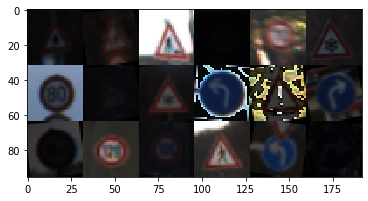

In [50]:
t.show_fails